# Homework 2
---------------------------------------------------------------------
## CIS 600 Fundamental Data & Knowledge Mining
## Prof. Ying Lin
## 11/7/2022

### Anthony Redamonti
### Syracuse University

### Introduction 
The following project was implemented in Jupyter Notebooks using Anaconda 3 with Python 3 (ipykernel). The goal of the project is below.

Analyze the dataset provided in the file "Weather Forcast Training.csv."
- Data Preparation & EDA
- Build, Tune, and Evaluate Decision Tree Models

Apply the classification models on the test dataset "Weather Forcast Testing.csv."
- Model Prediction

### Section 1: Data Preparation & EDA
- Handle Outliers
- Remove Duplicate Entries
- Replace Entries with Missing Data
- Replace Yes/No with 1/0.
- EDA: Heatmap

In [9]:
import pandas as pd
import numpy as np
import seaborn as sbn
import matplotlib.pyplot as mtpltlib

trainingData = pd.read_csv('Weather Forecast Training.csv')

print("(Rows, Columns): ", trainingData.shape)

(Rows, Columns):  (51978, 16)


#### Section 1.1: Handle Outliers

Certain features must be checked for outliers. 

An outlier will be defined in the following manner:
- The IQR must be found. The IQR is defined as the difference between the 75th and 25th percentiles of the data.
- Once the IQR is found, it is used to find the upper and lower thresholds that will be used to find outliers.
- The upper threshold is: 75th percentile + (1.5 * IQR)
- The lower threshold is: 25th percentile - (1.5 * IQR)

Find the total number of entries that contain outliers in the dataset. First, the following numeric ratio features will be checked for outliers: 
- MinTemp, MaxTemp, Rainfall, Evaporation, Sunshine, WindGustSpeed, WindSpeed, Humidity, Pressure, and Temp.

In [10]:
# Function that returns the indices of all the outliers in the dataset.
# Arguments are the dataset and a list of features.
def findOutlierIndexList(dataframe, inputFeatureList):
    
    outlierList = []
    
    for feature in inputFeatureList:
        quantile1 = dataframe[feature].quantile(0.25)
        quantile3 = dataframe[feature].quantile(0.75)
        interquartileRange = quantile3 - quantile1
        lowerThreshhold = quantile1 - (1.5 * interquartileRange)
        upperThreshhold = quantile3 + (1.5 * interquartileRange)
        
        index = 0
        
        # search the feature for outliers
        while(index < len(dataframe) - 1):
            value = dataframe._get_value(index, feature)
            if((value < lowerThreshhold) or (value > upperThreshhold)):
                outlierList.append(index)
            index = index + 1
                
    # remove repeating indices.
    outlierList = sorted(set(outlierList))
    return outlierList

# Define a list of numeric ratio features that may have outliers. 
featureList = ['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine', 'WindGustSpeed', 'WindSpeed', 'Humidity',
              'Pressure', 'Temp']

# Find the total number of outliers in the dataset.
outlierIndexList = findOutlierIndexList(trainingData, featureList)
totalNumberOfOutliers = len(outlierIndexList)
print("Percentage of Outliers:", '{:.2%}'.format(totalNumberOfOutliers / len(trainingData)))

Percentage of Outliers: 20.39%


#### 20.39% of the entries in the numeric ratio features contain outliers. 
- Because there is a high percentage of entries containing outliers, they cannot simply be removed from the dataset.

#### The outliers will be clipped so that they will fall within the range of acceptable values. 
- Any value greater than the upper threshold will be set equal to the upper threshold.
- Any value less than the lower threshold will be set equal to the lower threshold.
- The upper threshold is: 75th percentile + (1.5 * IQR)
- The lower threshold is: 25th percentile - (1.5 * IQR)

In [11]:
# Function that clips the value of outliers in the dataset.
# Arguments are the original dataset and a list of selected features.
def clipOutliers(dataframe, inputFeatureList):
    for feature in inputFeatureList:
        quantile1 = dataframe[feature].quantile(0.25)
        quantile3 = dataframe[feature].quantile(0.75)
        interquartileRange = quantile3 - quantile1
        lowerThreshhold = quantile1 - (1.5 * interquartileRange)
        upperThreshhold = quantile3 + (1.5 * interquartileRange)
        index = 0
    
        # search the feature for outliers
        while(index < len(dataframe) - 1):
            value = dataframe._get_value(index, feature)
            if(value < lowerThreshhold):
                dataframe._set_value(index, feature, lowerThreshhold)            
            if(value > upperThreshhold):
                dataframe._set_value(index, feature, upperThreshhold)            
            index = index + 1 

# clip the values of the outliers.
clipOutliers(trainingData, featureList)

# Find the total number of outliers in the dataset.
print("Total number of outliers found after clipping: ", len(findOutlierIndexList(trainingData, featureList)))

Total number of outliers found after clipping:  0


#### Section 1.2: Remove Duplicate Entries

The duplicate entries will be removed from the dataset.

In [12]:
originalLength = len(trainingData)

# drop all duplicate entries.
trainingData.drop_duplicates(inplace = True)

newLength = len(trainingData)
print("Number of duplicate entries dropped:", originalLength - newLength)

Number of duplicate entries dropped: 19


#### Section 1.3: Replace Entries with Missing Data
- The summary below displays the total number of NULL entries for each feature.

In [13]:
trainingData.isnull().sum()

Location             0
MinTemp            268
MaxTemp            116
Rainfall           745
Evaporation      22534
Sunshine         24856
WindGustDir       3579
WindGustSpeed     3552
WindDir           1494
WindSpeed         1005
Humidity          1410
Pressure          5047
Cloud            20111
Temp              1044
RainToday          745
RainTomorrow         0
dtype: int64

In [14]:
print("Percentage of entries with missing data:", '{:.2%}'.format((trainingData.isnull().sum(axis = 1) > 0).sum() / len(trainingData)))

Percentage of entries with missing data: 59.42%


#### 59.42% of the entries in the training dataset are incomplete. 
- The following attributes have a high number of missing entries: Evaporation, Sunshine, and Cloud.

In [15]:
print("Percentage of Evaporation entries with missing data:", '{:.2%}'.format(trainingData['Evaporation'].isnull().sum() / len(trainingData)))
print("Percentage of Sunshine entries with missing data:", '{:.2%}'.format(trainingData['Sunshine'].isnull().sum() / len(trainingData)))
print("Percentage of Cloud entries with missing data:", '{:.2%}'.format(trainingData['Cloud'].isnull().sum() / len(trainingData)))

Percentage of Evaporation entries with missing data: 43.37%
Percentage of Sunshine entries with missing data: 47.84%
Percentage of Cloud entries with missing data: 38.71%


Because of their high percentage of NULL entries, these three features will be removed from the dataset.

In [16]:
trainingData.drop('Evaporation', inplace = True, axis = 1)
trainingData.drop('Sunshine', inplace = True, axis = 1)
trainingData.drop('Cloud', inplace = True, axis = 1)

print("Percentage of entries with missing data:", '{:.2%}'.format((trainingData.isnull().sum(axis = 1) > 0).sum() / len(trainingData)))

Percentage of entries with missing data: 16.69%


#### After removing the above features, 16.69% of the entries in the training dataset remain incomplete. 

##### NULL values will be handled based on the data type of the feature.
- Ratio Numeric: NULL values will be replaced by the forward fill (ffill) value.
    - It makes sense to replace NULL values with the next entry's value (forward fill). While all of the outliers have been removed, the numeric ratio data remains diverse. Ffill is independent of the range of values of a numeric feature.
    
- Non-Ratio Numeric (except RainTomorrow): NULL values will be replaced by the most common entry in the feature.
    - A common method of replacing NULL values of nominal, categorical, and other feature types is using the most commonly used element.

##### Numeric Ratio Features: Replace NULL Using Ffill

- The function below "replaceNaWithFfill" replaces all NULL values of each feature in the feature list with the next entry's value. 
- The arguments are the dataset and a list of features to search.

In [17]:
def replaceNaWithFfill(dataframe, inputFeatureList):
    for feature in inputFeatureList:
        dataframe[feature] = dataframe[feature].fillna(method = 'ffill')
        
# Define a list of numeric ratio features that may have outliers. 
numRatioFeatureListNa = ['MinTemp', 'MaxTemp', 'Rainfall', 'WindGustSpeed', 'WindSpeed', 'Humidity',
              'Pressure', 'Temp']

replaceNaWithFfill(trainingData, numRatioFeatureListNa)

In [18]:
trainingData.isnull().sum()

Location            0
MinTemp             0
MaxTemp             0
Rainfall            0
WindGustDir      3579
WindGustSpeed       0
WindDir          1494
WindSpeed           0
Humidity            0
Pressure            0
Temp                0
RainToday         745
RainTomorrow        0
dtype: int64

The number of NULL entries for the numeric ratio features is now zero.

##### Nominal and Ordinal Features: Replace NULL Using the Most Common Value
The function below "replaceNaWithMCV" replaces all NULL values of each feature in the feature list with the most common value in the feature. The arguments are the dataset and a list of features to search.

In [19]:
# Function that replaces the NULL values in the dataset with the most common occurring value of the feature.
# Arguments are the original dataset and a list of selected features.
def replaceNaWithMCV(dataframe, inputFeatureList):
    for feature in inputFeatureList:
        mostCommonValue = dataframe[feature].value_counts().idxmax()
        dataframe[feature] = dataframe[feature].fillna(mostCommonValue)
        
# Define a list of non-numeric features that may have outliers. 
nonRatioList = ['WindGustDir', 'WindDir', 'RainToday']

replaceNaWithMCV(trainingData, nonRatioList)

In [20]:
trainingData.isnull().sum()

Location         0
MinTemp          0
MaxTemp          0
Rainfall         0
WindGustDir      0
WindGustSpeed    0
WindDir          0
WindSpeed        0
Humidity         0
Pressure         0
Temp             0
RainToday        0
RainTomorrow     0
dtype: int64

- All of the NULL entries in the non-numeric ratio features have been replaced by the most commonly occurring value.
- As shown in the above list, all of the NULL entries have been handled in each feature in the dataset. 

#### Section 1.4: Replace Yes/No with 1/0
- Boolean features that are in Yes/No format will be transformed to 1/0 numeric format for future decision tree building.

In [21]:
trainingData['RainToday'] = trainingData['RainToday'].replace("No", 0)
trainingData['RainToday'] = trainingData['RainToday'].replace("Yes", 1)
trainingData['RainTomorrow'] = trainingData['RainTomorrow'].replace("No", 0)
trainingData['RainTomorrow'] = trainingData['RainTomorrow'].replace("Yes", 1)

#### Section 1.5: One-hot Encoding
- "WindDir" and "WindGustDir" need to be transformed using one-hot encoding.
- After the one-hot encoded columns are added to the dataset, the original feature columns "WindDir" and "WindGustDir" will be removed as they are no longer needed.

In [22]:
# concatenate the one-hot encoding to the original dataframe
newWindDir = pd.get_dummies(trainingData.WindDir, prefix='WindDir')
trainingData = pd.concat([trainingData, newWindDir], axis = 1)
newWindGustDir = pd.get_dummies(trainingData.WindGustDir, prefix='WindGustDir')
trainingData = pd.concat([trainingData, newWindGustDir], axis = 1)

# remove old nominal columns
nominalFeatureList = ['WindDir', 'WindGustDir']
for feature in nominalFeatureList:
    trainingData.drop(feature, inplace = True, axis = 1)

#### Section 1.6: Drop Nominal "Location" Feature
- The Location feature will be dropped because it is a nominal attribute that is purely unique. No two locations repeat in the dataset. Therefore, it serves no purpose in determining if it will rain tomorrow.

In [23]:
trainingData.drop('Location', inplace = True, axis = 1)

#### Section 1.7: Exploratory Data Analysis (EDA)
- A heatmap will be created to show the correlations between different attributes.

<AxesSubplot:>

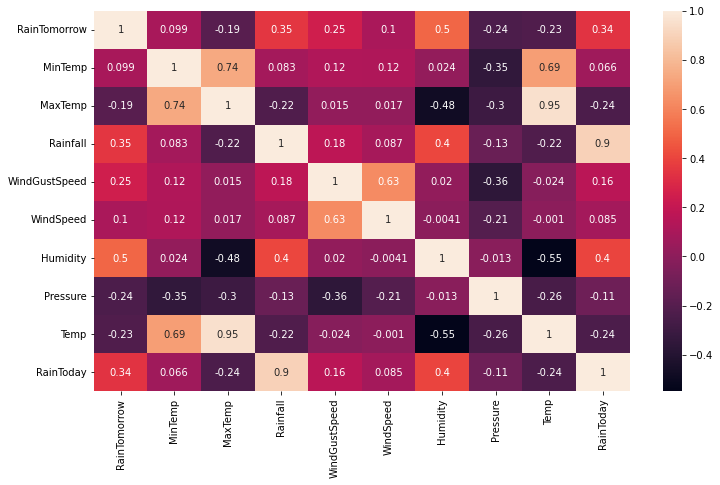

In [24]:
importantAttributes = trainingData[['RainTomorrow', 'MinTemp', 'MaxTemp', 'Rainfall', 'WindGustSpeed', 'WindSpeed', 'Humidity', 'Pressure', 'Temp', 'RainToday']]
mtpltlib.figure(figsize=(12,7))
correlation = importantAttributes.corr()
sbn.heatmap(correlation, annot = True)

#### The attribute with the highest correlation with "RainTomorrow" is "Humidity."

### Section 2: Build, Tune, and Evaluate Decision Tree Models

#### Section 2.1: Building a Decision Tree Model
- X_train represents 70% of the training dataset used for training purposes. 
- X_test represent 30% of the training dataset used for testing purposes.
- X_test is really the validation dataset because it originates from the training dataset. The testing dataset will be used later by loading a seperate CSV file.
- y_train represents the label "RainTomorrow" in the dataset, which is known.
- X_train and y_train are used in clf.fit to build a decision tree model.
- Once the model is built, it is used to predict the RainTomorrow label using X_test. 

<AxesSubplot:title={'center':'Predicted Y_Test'}, ylabel='Count'>

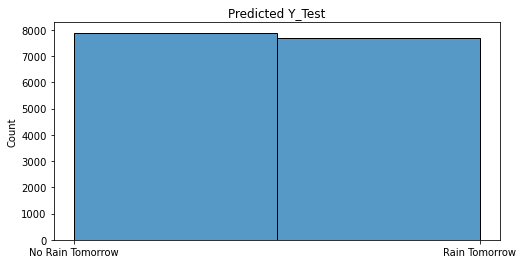

In [25]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, ShuffleSplit
from sklearn import metrics
from matplotlib import pyplot as plt
import seaborn as sbn

y = trainingData['RainTomorrow']
trainingData.drop('RainTomorrow', inplace = True, axis = 1)
X = trainingData

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 16)
clf = DecisionTreeClassifier()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

plt.figure(figsize=(8,4))
plt.title("Predicted Y_Test")
plt.xticks([0, 1], ['No Rain Tomorrow', 'Rain Tomorrow'])
sbn.histplot(data = y_pred, bins = 2)

In [54]:
dfPred = pd.DataFrame(y_pred, columns = ['Rain Tomorrow'])
print("Entries with No Rain Tomorrow: " + str((dfPred[dfPred.columns[0]] == 0).sum()))
print("Entries with Rain Tomorrow: " + str((dfPred[dfPred.columns[0]] == 1).sum()))

Entries with No Rain Tomorrow: 7895
Entries with Rain Tomorrow: 7693


- Above is the plot of y_pred, which is the predicted contents of y_test. 
- Results: 
        - No Rain Tomorrow: 7,895 entries. 
        - Rain Tomorrow: 7,693 entries.
- How does y_pred compare with the actual contents of y_test?

In [26]:
print(f"Accuracy: {round(metrics.accuracy_score(y_test, y_pred)*100, 2)}%")
df_confusion = pd.crosstab(y_test, y_pred)
df_confusion.index = [['Real', 'Real'], ['No Rain Tomorrow', 'Rain Tomorrow']]
df_confusion.columns = [['Predict', 'Predict'], ['No Rain Tomorrow', 'Rain Tomorrow']]
df_confusion

Accuracy: 69.37%


Predict              
                      No Rain Tomorrow Rain Tomorrow
Real No Rain Tomorrow             5502          2382
     Rain Tomorrow                2393          5311

- The model accuracy is 69.37%.
- Above are the accuracy and confusion matrix of the model.
    - True Positives: 5,311
    - False Positives: 2,382
    - True Negatives: 5,502
    - False Negatives: 2,393

In [27]:
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.70      0.70      0.70      7884
           1       0.69      0.69      0.69      7704

    accuracy                           0.69     15588
   macro avg       0.69      0.69      0.69     15588
weighted avg       0.69      0.69      0.69     15588



- Above is the metrics report.
- The F1 score is the harmonic mean of recall and precision. 
    - Weighted Average F1 score: 0.69.
- Recall takes the false negatives into account. Recall = True Positives / (True Positives + False Negatives).
    - Weighted Average Recall = 0.69. 
- Precision takes the false positives into account. Precision = True Positives / (True Positives + False Positives).
    - Weighted Average Precision = 0.69.

#### Section 2.2: Decision Tree Model Hyperparameter Tuning
- The hyperparameters of the decision tree must be tuned. 
- The param_grid is filled with sets of hyperparameters to test.
- The GridSearchCV Cross-validation estimator will exhaustively perform cross-validation testing using all of the possible combinations of hyperparameters specified in the param_grid. 
- The GridSearchCV method will use a cross validation fold of 10, which means:
    - The data is split into 90% training data and 10% testing data.
    - Each combination of hyperparameters is tested 10 times, swapping training and testing data selection for each test.

In [28]:
# Hyperparameter Grid Search
param_grid = {'criterion': ['gini', 'entropy'],
             'min_samples_split': [2, 10, 20, 30],
             'max_depth': [4, 6, 10, 20, 30],
             'min_samples_leaf': [1, 2, 5, 10],
             'max_leaf_nodes': [10, 20, 25, 30]}

grid = GridSearchCV(clf, param_grid, cv = 10)
grid.fit(X_train, y_train)

# Hyperparameters for Best Performing Model
print(f"Accuracy: {round(grid.best_score_*100, 2)}%")
for key, value in grid.best_params_.items():
    print(f"Hyperparameter: {key}; Value: {value}")

Accuracy: 75.71%
Hyperparameter: criterion; Value: gini
Hyperparameter: max_depth; Value: 10
Hyperparameter: max_leaf_nodes; Value: 30
Hyperparameter: min_samples_leaf; Value: 1
Hyperparameter: min_samples_split; Value: 2


- The hyperparameter tuning is complete. Above are the hyperparameter settings that yield the best performance. 
- The criterion hyperparameter represents the method for deciding the data purity for the decision tree induction algorithm.
    - The best method is the gini index. 
- The other hyperparameters determine the model complexity (i.e. the size of the model). The selection for these hyperparameters that yielded the best performance is below.
    - Max Depth: 10
    - Max Leaf Nodes: 30
    - Min Leaf Samples: 1
    - Min Split Samples: 2
- The best performance score (accuracy) was 75.71%.  

##### ShuffleSplit Method
- Another method of sampling data during the cross-validation stage is the ShuffleSplit method. It will randomly sample data for each iteration.
- It will be used below to generate random samples of training/validation data. 
- The size of the data samples is set using the test_size parameter.
- The number of sections to split the data is set by the n_splits parameter.

In [29]:
bstrap = ShuffleSplit(n_splits = 10, test_size = 0.3, random_state = 16)
grid_bstrap = GridSearchCV(clf, param_grid, cv = bstrap)
grid_bstrap.fit(X_train, y_train)

# Hyperparameters for Best Performing Model
print(f"Accuracy: {round(grid_bstrap.best_score_*100, 2)}%")
for key, value in grid_bstrap.best_params_.items():
    print(f"Hyperparameter: {key}; Value: {value}")

Accuracy: 75.65%
Hyperparameter: criterion; Value: gini
Hyperparameter: max_depth; Value: 10
Hyperparameter: max_leaf_nodes; Value: 30
Hyperparameter: min_samples_leaf; Value: 1
Hyperparameter: min_samples_split; Value: 2


- The ShuffleSplit method of data sampling produced the same properties of the trained model.
    - Criterion: Gini Index
    - Max Depth: 10
    - Max Leaf Nodes: 30
    - Min Leaf Samples: 1
    - Min Split Samples: 2
- The best performance score (accuracy) was 75.65%.  

#### Section 2.3: Decision Tree Model Performance Evaluation
##### ROC/AUC Plot
- The following section will measure the performance of the model by evaluating the Area Under Curve (AUC) score and by building a Receiver Characteristic Curve (ROC).
- The AUC/ROC measures the model's ability to distinguish between the classes.
    - The arguments for the AUC/ROC curve are the predicted probability for target label and the target label.
- The predict_proba method of the GridSearchCV module will be used to predict the probability that the data will belong to the class label "RainTomorrow."

AUC = 0.8294070074623052


Text(0, 0.5, 'Sensitivity')

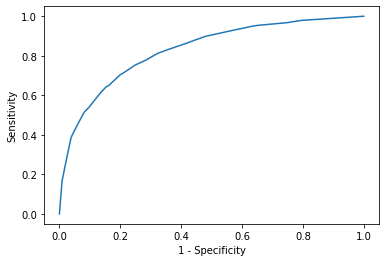

In [30]:
from sklearn.metrics import roc_auc_score, roc_curve

# predict the probability it will rain tomorrow (1)
y_pred_prob = grid.predict_proba(X_test)[:, 1]

areaUnderCurve = roc_auc_score(y_test, y_pred_prob)
print(f"AUC = {areaUnderCurve}")
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)

sbn.lineplot(x = fpr, y = tpr)
plt.xlabel('1 - Specificity')
plt.ylabel('Sensitivity')

##### The area under the curve is 0.8294.
- The specificity measures the proportion of true negatives that were correctly identified by the model. It takes into account false positives.
- The sensitivity measures how well the model detected positive instances. It is also known as Recall and takes into account false negatives.
- The ROC curve is constructed by plotting the True Positive Rate (TPR) against the False Positive Rate (FPR). 
- TPR = TP / (TP + FN)
- FPR = FP / (TN + FP)

### Section 3: Model Prediction (Weather Forecast Testing.csv)
- The model will now be used to predict the values of the RainTomorrow attribute of the testing dataset.
- The data will be cleaned before being used by the model.

In [73]:
# read in the testing dataset (.csv file)
testData = pd.read_csv('Weather Forecast Testing.csv')

# clip the values of the outliers.
clipOutliers(testData, featureList)

# drop all duplicate entries.
testData.drop_duplicates(inplace = True)

# remove features with high percentage of NULL values.
testData.drop('Evaporation', inplace = True, axis = 1)
testData.drop('Sunshine', inplace = True, axis = 1)
testData.drop('Cloud', inplace = True, axis = 1)

# Numeric Ratio Types: Replace NULL values with forward fill value
replaceNaWithFfill(testData, numRatioFeatureListNa)

# Non-numeric Types: Replace NULL values with the most common value
replaceNaWithMCV(testData, nonRatioList)

# replace Yes/No with 1/0 binary values.
testData['RainToday'] = testData['RainToday'].replace("No", 0)
testData['RainToday'] = testData['RainToday'].replace("Yes", 1)

# concatenate the one-hot encoding to the original dataframe
newWindDirTest = pd.get_dummies(testData.WindDir, prefix='WindDir')
testData = pd.concat([testData, newWindDirTest], axis = 1)
newWindGustDirTest = pd.get_dummies(testData.WindGustDir, prefix='WindGustDir')
testData = pd.concat([testData, newWindGustDirTest], axis = 1)

# remove old nominal columns that were one-hot encoded.
testData.drop('WindDir', inplace = True, axis = 1)
testData.drop('WindGustDir', inplace = True, axis = 1)
testData.drop('Location', inplace = True, axis = 1)

# record the ID feature and drop it from the original dataframe.
idFeature = testData['ID']
testData.drop('ID', inplace = True, axis = 1)

print("(Rows, Columns): ", testData.shape)

(Rows, Columns):  (12994, 41)


#### The testing dataset is now cleaned and ready to use in the model.

In [74]:
# convert dataframe to numpy array
testDataNpArr = testData.to_numpy()

# predict the outcome using the test data
prediction = grid.predict(testDataNpArr)

# change the binary attribute (1/0) to Yes/No format
yesNoList = []
for item in prediction:
    if(item == 1):
        yesNoList.append("Yes")
    elif(item == 0):
        yesNoList.append("No")

predictionArr = np.array(yesNoList)
        
# convert the ID attribute to numpy array
idFeature = idFeature.to_numpy()

# combine the ID with the prediction
combined = np.vstack((idFeature, predictionArr)).T

C:\Users\aredamonti\Anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


#### The prediction data is ready to be exported to a CSV file.

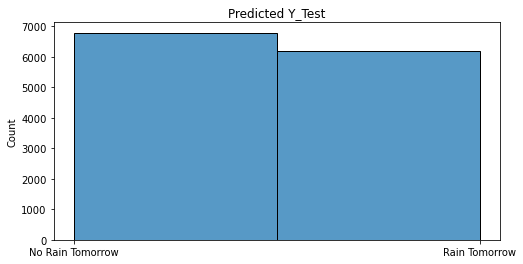

In [75]:
# plot the results
plt.figure(figsize=(8,4))
plt.title("Predicted Y_Test")
plt.xticks([0, 1], ['No Rain Tomorrow', 'Rain Tomorrow'])
sbn.histplot(data = prediction, bins = 2)

# save the data to a CSV file
newDataFrameTest = pd.DataFrame(combined)
newDataFrameTest.to_csv('Prediction.csv',index=False)

In [80]:
print("Entries with No Rain Tomorrow: " + str((newDataFrameTest[newDataFrameTest.columns[1]] == 'No').sum()))

Entries with No Rain Tomorrow: 6792


In [81]:
print("Entries with Rain Tomorrow: " + str((newDataFrameTest[newDataFrameTest.columns[1]] == 'Yes').sum()))

Entries with Rain Tomorrow: 6202


- The above plot shows the prediction results. 
- The model prediction is below:
    - Rain Tomorrow: 6,202 
    - No Rain Tomorrow: 6,792

#### The column titles shall be "ID" and "DT".
- The below code formats the title of the csv file to "ID" and "DT".

In [82]:
import csv

# read in the contents of the CSV file
file = open('Prediction.csv', 'r')
fileReader = csv.reader(file)
listCsv = list(fileReader)
file.close()

# alter the titles of the columns to "ID" and "DT"
listCsv[0][0] = 'ID'
listCsv[0][1] = 'DT'

# write the altered file contents to the CSV file
newListCsv = open('Prediction.csv', 'w', newline = '')
fileWriter = csv.writer(newListCsv)
fileWriter.writerows(listCsv)
newListCsv.close()